In [ ]:
! pip install -q -U sentence-transformers datasets huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00


In [ ]:
#from huggingface_hub import login
#login()

- 1 : Neutral
- 2 : contradiction
- 0 : entailment

Reference : https://www.youtube.com/watch?v=or5ew7dqA-c&list=PL5aStiCXsx-xlIzqcnJkm9TcyDlnm_uP1&index=6

## Loading Dataset

https://huggingface.co/datasets/snli

In [ ]:
from datasets import load_dataset

dataset = load_dataset("snli",split='train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

In [ ]:
dataset

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 550152
})

In [ ]:
dataset[:5]

{'premise': ['A person on a horse jumps over a broken down airplane.',
  'A person on a horse jumps over a broken down airplane.',
  'A person on a horse jumps over a broken down airplane.',
  'Children smiling and waving at camera',
  'Children smiling and waving at camera'],
 'hypothesis': ['A person is training his horse for a competition.',
  'A person is at a diner, ordering an omelette.',
  'A person is outdoors, on a horse.',
  'They are smiling at their parents',
  'There are children present'],
 'label': [1, 2, 0, 1, 0]}

### Preprocessing Data
The creators of datasets have placed label of '-1' if they didn't think other labels fit for the texts, so we remove those examples.<br>
https://huggingface.co/docs/datasets/en/process

In [ ]:
dataset = dataset.filter(
    lambda x: False if x['label']  == -1 else True
)

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 549367
})

MNR(Multiple Negatives Ranking) Loss: https://www.youtube.com/watch?v=b_2v9Hpfnbw

Anchoring only positive pairs

In [ ]:
data_mnr = dataset.filter(
    lambda x: False if x['label'] != 0 else True
)
data_mnr

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 183416
})

In [ ]:
data_mnr

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 183416
})

In [ ]:
data_mnr = data_mnr.select(indices=range(50000))

In [ ]:
data_mnr

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 50000
})

In [ ]:
from sentence_transformers import InputExample
from tqdm.auto import tqdm

samples = []
for row in tqdm(data_mnr):
  samples.append(InputExample(
      texts = [row['premise'], row['hypothesis']]
  ))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
from sentence_transformers import datasets

batch_size = 128 # Set according to Gpu Memory

loader = datasets.NoDuplicatesDataLoader(
    train_examples= samples,
    batch_size= batch_size
)

## Initializing Model

In [ ]:
from sentence_transformers import SentenceTransformer, models

model = models.Transformer('bert-base-uncased')
pooling = models.Pooling(
    model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
)

model = SentenceTransformer(modules=[model,pooling])
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
)

### Initializing Loss Function

In [ ]:
from sentence_transformers import losses

loss = losses.MultipleNegativesRankingLoss(model)

### Defining Training Loop

In [ ]:
epochs = 1
warmup = int(0.1*len(loader))
model.fit(
    train_objectives=[(loader,loss)],
    epochs = epochs,
    warmup_steps=warmup,
    output_path='/content/bert_snli'
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/390 [00:00<?, ?it/s]

In [ ]:
sentences = [
    'He slept by the bank.',
    'He withdrew cash from the bank.',
    'He went to the ATM and withdrew money.'
]

In [ ]:
model = SentenceTransformer('/content/bert_snli')

In [ ]:
embeds = model.encode(sentences=sentences)

In [ ]:
from sentence_transformers.util import cos_sim
import torch

cos_sim = cos_sim(embeds,embeds)

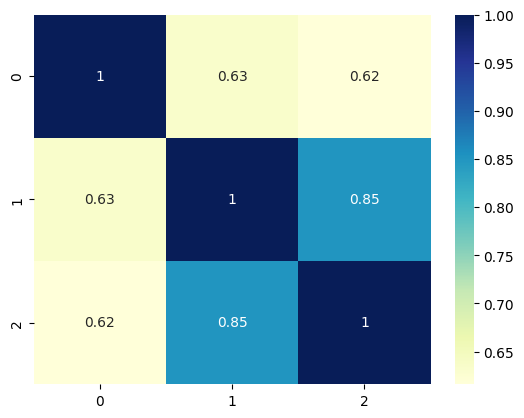

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cos_sim.numpy(), annot=True, cmap="YlGnBu")
plt.show()

*Testing agaisnt Newer Model (at the time of making)*

In [ ]:
from sentence_transformers.util import cos_sim

In [ ]:
model2 = SentenceTransformer('BAAI/bge-base-en-v1.5')
embeds2 = model.encode(sentences=sentences)

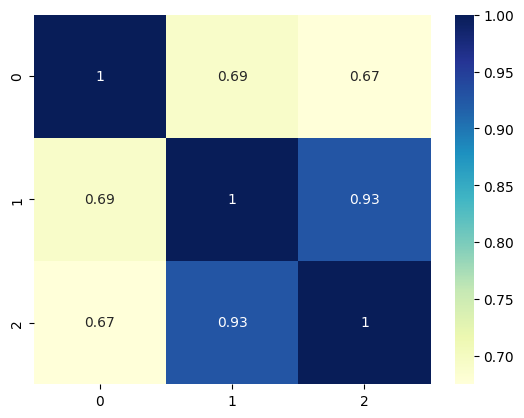

In [ ]:
cos_sim_ = cos_sim(embeds2,embeds2)
sns.heatmap(cos_sim_.numpy(), annot=True, cmap="YlGnBu")
plt.show()

Newer model somewhat give higher  similaity (not by much) between unrelated data. It seems both models have poor peformance on unrelated data, where similarity should be ideally 0 (orthognal).